# Constant Velocity #

In [164]:
from route_generation import *
from visual_tools import *
import evaluation_tools
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


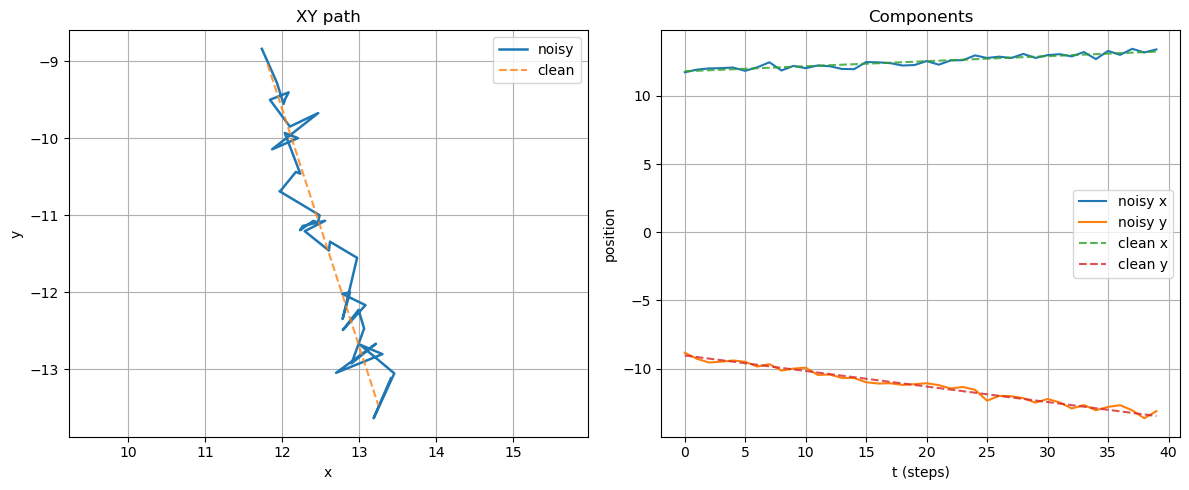

In [6]:
# 2D path, vx=3 m/s, vy=1 m/s, σ=0.2 m on both axes
NOISE = np.array([0.2, 0.2])
start = np.zeros(2)
v = [0.0, 1.0]
x0 = np.array([start[0], v[0], start[1], v[1]])
traj, clean = generate_cv_trajectory(T=40, dt=0.04, dim=2, v=None, x0=None,
                              noise_std=NOISE, number_of_trajectories=2, seed=19)[0]

plot_trajectory_with_kf(traj, show_clean=clean)


F shape: (4, 4)
H shape: (2, 4)
Q shape: (4, 4)
P0 shape: (4, 4)
trans_offset shape: (4,)
R shape: (2, 2)
x0 shape: (4,)
{'mse': 0.0018729658940623867, 'per_axis': np.float64(0.0018729658940623867)}
21.187804468030215


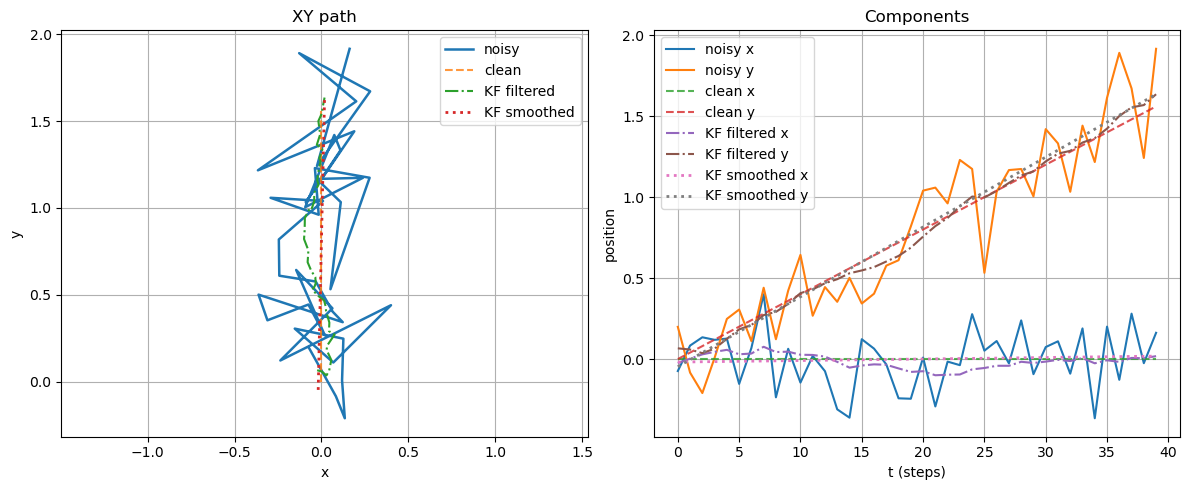

In [19]:
import numpy as np
from pykalman import KalmanFilter

# ---------------------------
# 1) Matrices (explicit, no kron)
# ---------------------------
def cv_matrices(dim: int, dt: float):
    """
    Constant-velocity model (positions only observed).
    State per axis: [pos, vel]; overall state: [x, vx, y, vy, (z, vz)]
    Returns F, H, Q (Q=0 here).
    """
    assert dim in (2, 3)
    if dim == 2:
        F = np.array([
            [1, dt, 0,  0],
            [0,  1, 0,  0],
            [0,  0, 1, dt],
            [0,  0, 0,  1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0],  # measure x
            [0, 0, 1, 0],  # measure y
        ], dtype=float)
        Q = np.zeros((4, 4), dtype=float)   # no process noise
    else:  # dim == 3
        F = np.array([
            [1, dt, 0,  0,  0,  0],
            [0,  1, 0,  0,  0,  0],
            [0,  0, 1, dt,  0,  0],
            [0,  0, 0,  1,  0,  0],
            [0,  0, 0,  0,  1, dt],
            [0,  0, 0,  0,  0,  1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0, 0, 0],  # x
            [0, 0, 1, 0, 0, 0],  # y
            [0, 0, 0, 0, 1, 0],  # z
        ], dtype=float)
        Q = np.zeros((6, 6), dtype=float)   # no process noise
    return F, H, Q

def make_kf(F, H, Q, R, x0, P0):
    """Build the pykalman.KalmanFilter with your matrices."""
    return KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        transition_covariance=Q,
        observation_covariance=R,
        initial_state_mean=x0,
        initial_state_covariance=P0,
    )

# ---------------------------
# 2) Run the KF (+ optional EM on R)
# ---------------------------
def run_cv(kf: KalmanFilter, measurements: np.ndarray, em_iters: int = 0):
    """
    measurements: [T, dim] positions only.
    em_iters=0 -> just filter/smooth with given R.
    em_iters>0 -> first estimate R via EM (only observation_covariance), then filter/smooth.

    Returns dict with filtered/smoothed states + learned R (if EM used).
    """
    if em_iters > 0:
        kf = kf.em(measurements, n_iter=em_iters, em_vars=['observation_covariance'])

    xf, Pf = kf.filter(measurements)
    xs, Ps = kf.smooth(measurements)
    dim = measurements.shape[1]
    out = {
        "filtered_x": xf, "filtered_P": Pf,
        "smoothed_x": xs, "smoothed_P": Ps,
        "pos_filt": xf[:, :2*dim:2],     # take every (pos,vel) pair's pos -> indices 0,2,(4)
        "vel_filt": xf[:, 1:2*dim:2],    # corresponding velocities -> indices 1,3,(5)
        "pos_smooth": xs[:, :2*dim:2],
        "vel_smooth": xs[:, 1:2*dim:2],
    }
    if em_iters > 0:
        out["R_learned"] = kf.observation_covariance
    return out
F, H, Q = cv_matrices(2, 0.04)
P0 = np.eye(x0.shape[0]) * 1e-1
transition_offsets = np.zeros((F.shape[0]))
R = np.diag(NOISE)
print(f"F shape: {F.shape}")
print(f"H shape: {H.shape}")
print(f"Q shape: {Q.shape}")
print(f"P0 shape: {P0.shape}")
print(f"trans_offset shape: {transition_offsets.shape}")
print(f"R shape: {R.shape}")
print(f"x0 shape: {x0.shape}")

kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_offsets=transition_offsets,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0
)
#print(traj.shape)
#print(clean.shape)
# e.g., traj = generate_cv_trajectory(...), shape (T, dim)
xf, Pf = kf.filter(traj)
xs, Ps = kf.smooth(traj)

print(evaluation_tools.compute_mse(xf[:,[0,2]], clean))
print(evaluation_tools.compute_nll(kf, traj)) #TODO: Need to understand how to interpret this
plot_trajectory_with_kf(traj, clean, kf_filt=xf[:, [0,2]], kf_smooth=xs[:, [0,2]])

### Now with unknown covariances ###

In [146]:
# 2D path, vx=3 m/s, vy=1 m/s, σ=0.2 m on both axes
NOISE = np.array([1.2,1.2])
start = np.zeros(2)
v = [3.0, 1.0]
x0 = np.array([start[0], v[0], start[1], v[1]])
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=v, x0=start,
#                              noise_std=NOISE, seed=14)
#plot_trajectory_with_kf(traj, show_clean=clean)


[[1.   0.04 0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.04]
 [0.   0.   0.   1.  ]]
learned observation cov: 
[[1.39105985 0.        ]
 [0.         1.39945334]]
learned transition cov: 
[[0.         0.         0.         0.        ]
 [0.         1.04741488 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.96678461]]


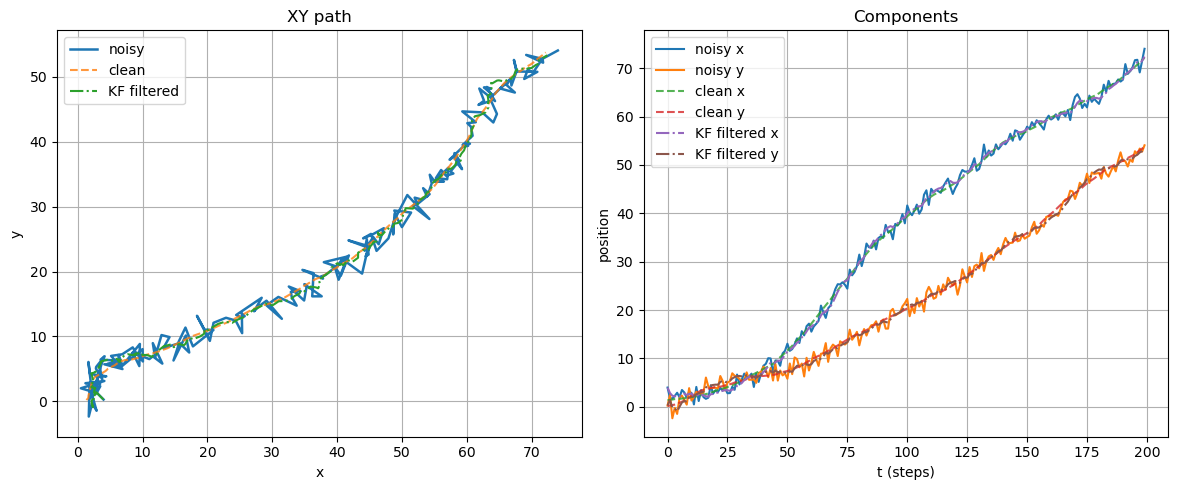

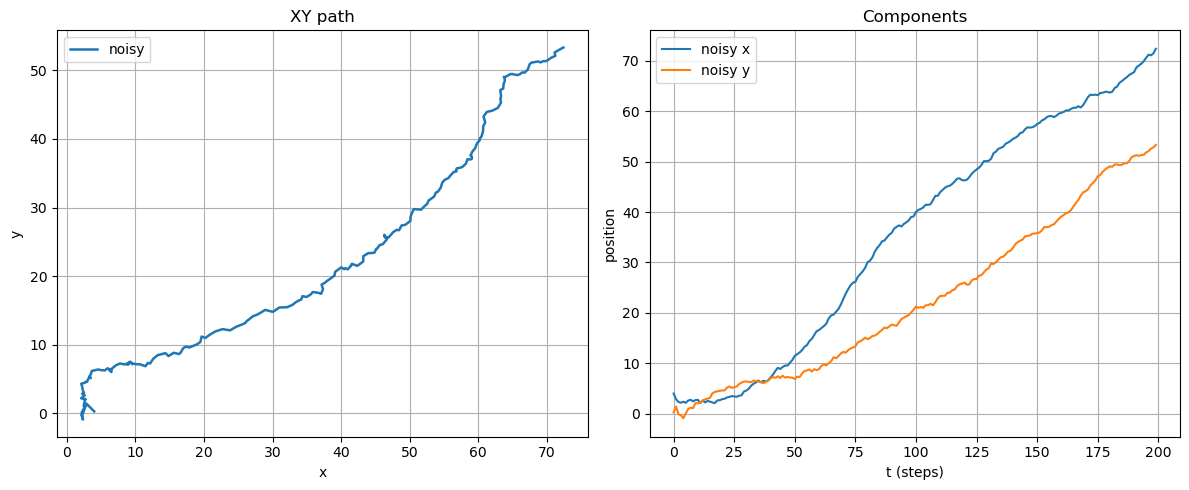

In [188]:
import numpy as np
from pykalman import KalmanFilter

# ---------------------------
# 1) Matrices (explicit, no kron)
# ---------------------------
def cv_matrices(dim: int, dt: float):
    """
    Constant-velocity model (positions only observed).
    State per axis: [pos, vel]; overall state: [x, vx, y, vy, (z, vz)]
    Returns F, H, Q (Q=0 here).
    """
    assert dim in (2, 3)
    if dim == 2:
        F = np.array([
            [1, dt, 0,  0],
            [0,  1, 0,  0],
            [0,  0, 1, dt],
            [0,  0, 0,  1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0],  # measure x
            [0, 0, 1, 0],  # measure y
        ], dtype=float)
        Q = np.zeros((4, 4), dtype=float)   # no process noise
    else:  # dim == 3
        F = np.array([
            [1, dt, 0,  0,  0,  0],
            [0,  1, 0,  0,  0,  0],
            [0,  0, 1, dt,  0,  0],
            [0,  0, 0,  1,  0,  0],
            [0,  0, 0,  0,  1, dt],
            [0,  0, 0,  0,  0,  1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0, 0, 0],  # x
            [0, 0, 1, 0, 0, 0],  # y
            [0, 0, 0, 0, 1, 0],  # z
        ], dtype=float)
        Q = np.zeros((6, 6), dtype=float)   # no process noise
    return F, H, Q

import numpy as np

def clip_F_to_cv(F: np.ndarray) -> np.ndarray:
    """
    Zero out all entries of F that are not part of the constant-velocity (CV) form.
    Works for 2D or 3D (inferred from shape). Supports time-invariant (n,n) or
    time-varying (T,n,n) F from pykalman.EM.

    CV allowed (per axis a):
      let i = 2*a
      keep (i,i), (i,i+1), (i+1,i+1)
      zero everything else.
    """
    F = np.asarray(F)
    if F.ndim == 2:
        n = F.shape[0]
        assert F.shape[0] == F.shape[1], "F must be square"
        assert n % 2 == 0, "state must be [pos,vel] per axis → even dimension"
        dim = n // 2
        mask = np.zeros((n, n), dtype=bool)
        for a in range(dim):
            i = 2 * a
            mask[i, i] = True          # pos ← pos
            mask[i, i+1] = True        # pos ← vel
            mask[i+1, i+1] = True      # vel ← vel
        dt_hat = (F[0,1] + F[2,3]) / 2
        F_clip = np.where(mask, F, 0.0)
        F_clip[0,1] = dt_hat
        F_clip[2,3] = dt_hat
        return F_clip

    elif F.ndim == 3:
        T, n, n2 = F.shape
        assert n == n2, "F must be (T,n,n)"
        assert n % 2 == 0
        dim = n // 2
        mask = np.zeros((n, n), dtype=bool)
        for a in range(dim):
            i = 2 * a
            mask[i, i] = True
            mask[i, i+1] = True
            mask[i+1, i+1] = True
        # broadcast mask over time
        F_clip = np.where(mask[None, :, :], F, 0.0)
        return F_clip

    else:
        raise ValueError("F must be (n,n) or (T,n,n)")

# --- Keep R diagonal, bounded, PSD ---
def project_R_to_diag(R: np.ndarray, rmin=1e-6, rmax=10) -> np.ndarray:
    R = 0.5*(R + R.T)
    d = np.clip(np.diag(R), rmin, rmax)
    return np.diag(d)

# --- Project Q to velocity random-walk per-axis blocks: [[0,0],[0,qv]] ---
def project_Q_to_velRW(Q: np.ndarray,
                       dim: int = 2,
                       tie_axes: bool = False,
                       q_bounds=(1e-8, 1e+3)) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns (Q_projected, qv_per_axis).
    """
    Q = 0.5*(Q + Q.T)
    n = 2*dim
    Qp = np.zeros((n,n), float)
    # read per-axis v-variance candidates
    qv_list = []
    for a in range(dim):
        i = 2*a
        qv_list.append(max(0.0, float(Q[i+1, i+1])))
    if tie_axes:
        qv = float(np.clip(np.median(qv_list), *q_bounds))
        for a in range(dim):
            i = 2*a
            Qp[i+1, i+1] = qv
        return Qp, np.array([qv]*dim)
    else:
        qv_arr = np.clip(np.array(qv_list), q_bounds[0], q_bounds[1])
        for a, qv in enumerate(qv_arr):
            i = 2*a
            Qp[i+1, i+1] = float(qv)
        return Qp, qv_arr

# ---------------------------
# 2) Run the KF (+ optional EM on R)
# ---------------------------
def run_cv(kf: KalmanFilter, measurements: np.ndarray, em_iters: int = 0, estimate_v: bool = False):
    """
    measurements: [T, dim] positions only.
    em_iters=0 -> just filter/smooth with given R.
    em_iters>0 -> first estimate R via EM (only observation_covariance), then filter/smooth.

    Returns dict with filtered/smoothed states + learned R (if EM used).
    """
    if em_iters > 0:
        for i in range(em_iters):
        #kf = kf.em(measurements, n_iter=em_iters, em_vars=['observation_covariance'])
            if estimate_v:
                vx0_hat = (measurements[1,0] - measurements[0,0]) / 0.04
                vy0_hat = (measurements[1,1] - measurements[0,1]) / 0.04
            else:
                vx0_hat = 0
                vy0_hat = 0
            x0 = np.array([measurements[0,0], 0, measurements[0,1], 0])
            kf.initial_state_mean = x0
            kf = kf.em(measurements, n_iter=1, em_vars=['observation_covariance',
                                                        #'transition_matrices',
                                                        'transition_covariance',
                                                        #'initial_state_mean',
                                                        #'initial_state_covariance',
                                                               ])
            kf.observation_covariance = project_R_to_diag(kf.observation_covariance)
            kf.transition_covariance = project_Q_to_velRW(kf.transition_covariance)[0]
        

    xf, Pf = kf.filter(measurements)
    xs, Ps = kf.smooth(measurements)
    dim = measurements.shape[1]
    out = {
        "filtered_x": xf, "filtered_P": Pf,
        "smoothed_x": xs, "smoothed_P": Ps,
        "pos_filt": xf[:, :2*dim:2],     # take every (pos,vel) pair's pos -> indices 0,2,(4)
        "vel_filt": xf[:, 1:2*dim:2],    # corresponding velocities -> indices 1,3,(5)
        "pos_smooth": xs[:, :2*dim:2],
        "vel_smooth": xs[:, 1:2*dim:2],
    }
    if em_iters > 0:
        out["R_learned"] = kf.observation_covariance
        out["F_learned"] = kf.transition_matrices
    return out

F, H, Q = cv_matrices(2, 0.04)
Q = np.eye(4, 4) * 1e1
#Q = np.zeros((4,4), float)
#qv = 1e-2                    # try 1e-5 … 1e-3
#Q[1,1] = qv; Q[3,3] = qv     # process variance on velocities only


#P0 = np.diag([1e-8, 1/3, 1e-8, 1/3])
P0 = np.eye(4) *1e2
#P0 = np.zeros((x0.shape[0],x0.shape[0]))
transition_offsets = np.zeros((F.shape[0]))
R = np.diag(NOISE**2)

#Initial Estimation for R
#R0 = np.diag(np.maximum(np.var(traj - clean, axis=0), 1e-6))
#print(f"F shape: {F.shape}")
#print(f"H shape: {H.shape}")
#print(f"Q shape: {Q.shape}")
#print(f"P0 shape: {P0.shape}")
#print(f"trans_offset shape: {transition_offsets.shape}")
#print(f"R shape: {R.shape}")
#print(f"x0 shape: {x0.shape}")

kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_offsets=transition_offsets,
    transition_covariance=Q, #Process noise
#    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0,
)
print(F)
#print(clean.shape)
# e.g., traj = generate_cv_trajectory(...), shape (T, dim)
trajectories = generate_cv_with_micro_velocity_changes(T=200, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE, number_of_trajectories=40, accel_std=[1,1], seed=14)
em_iters = 3
for traj, clean in trajectories:
    result = run_cv(kf, traj, em_iters=em_iters)
    if em_iters:
        pass
        #print(f"learned observation covariance: \n{result['R_learned']}")
        #print(f"learned transition matrix: \n{result['F_learned']}")
    #print(kf.transition_matrices)
    #plot_trajectory_with_kf(traj, kf_filt=result["pos_filt"])#, kf_smooth=result["pos_smooth"])

print(f"learned observation cov: \n{kf.observation_covariance}")
print(f"learned transition cov: \n{kf.transition_covariance}")
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=None, x0=None,
#                              noise_std=NOISE, seed=15)[0]
traj, clean = generate_cv_with_micro_velocity_changes(T=200, dt=0.04, dim=2, v=None, x0=None,
                              noise_std=NOISE, accel_std=[1,1], seed=15)[0]
em_iters = 0
kf.initial_state_mean[0] = traj[0,0]
kf.initial_state_mean[2] = traj[0,1]

result = run_cv(kf, traj, em_iters=em_iters)
plot_trajectory_with_kf(traj, show_clean=clean, kf_filt=result["pos_filt"])#, kf_smooth=result["pos_smooth"])
plot_trajectory_with_kf(result["pos_filt"])

# Constant Acceleration #

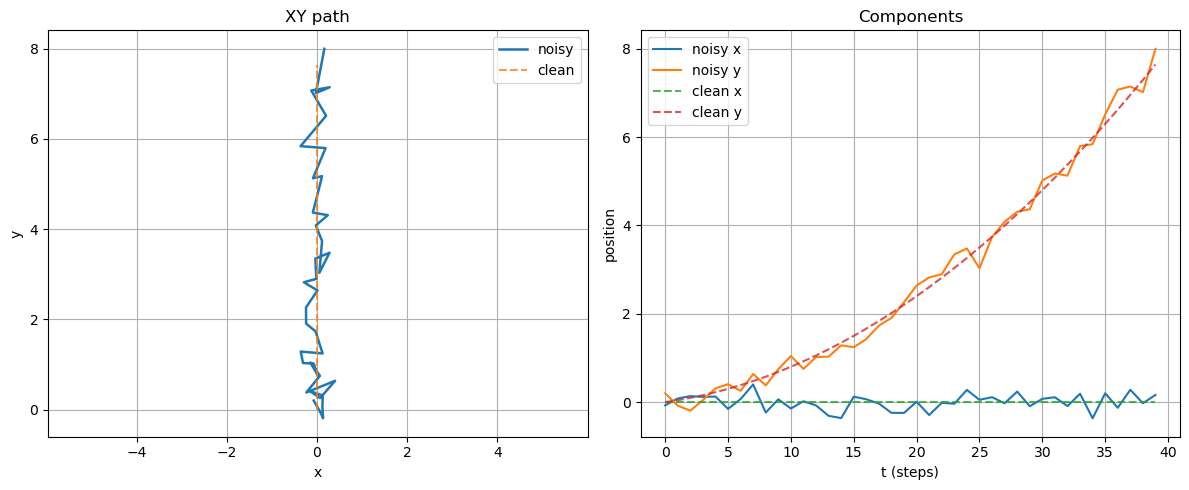

In [42]:
NOISE = np.array([0.2, 0.2])
start = np.zeros(2)
v = [0.0, 1.0]
a = [0.0, 5.0]
x0 = np.array([start[0], v[0], start[1], v[1]])
traj, clean = generate_ca_trajectory(T=40, dt=0.04, dim=2, a=a, v0=v, x0=start,
                              measurement_noise_std=NOISE, seed=19)

plot_trajectory_with_kf(traj, show_clean=clean)


{'mse': 0.15867161338893446, 'per_axis': np.float64(0.15867161338893446)}
227.72431603902012


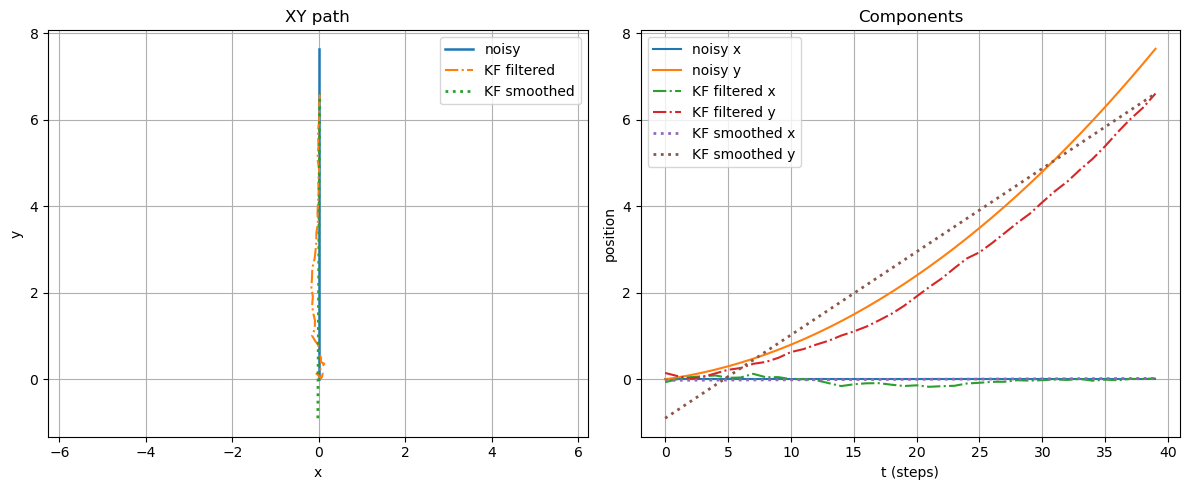

In [43]:
xf, Pf = kf.filter(traj)
xs, Ps = kf.smooth(traj)

print(evaluation_tools.compute_mse(xf[:,[0,2]], clean))
print(evaluation_tools.compute_nll(kf, traj)) #TODO: Need to understand how to interpret this
plot_trajectory_with_kf(clean, kf_filt=xf[:, [0,2]], kf_smooth=xs[:, [0,2]])
